Run the code here : 

[[   0.         0.         0.         0.         0.         0.
     0.         0.         0.         0.         0.         0.
     0.         0.         0.         0.         0.         0.
     0.         0.         0.         0.         0.         0.
     0.         0.         0.         0.     ]
 [   0.      2807.10144    0.         0.         0.         0.
     0.         0.         0.         0.         0.         0.
     0.         0.         0.         0.         0.         0.
     0.         0.         0.         0.         0.         0.
     0.         0.         0.         0.     ]
 [   0.         0.         0.         0.         0.         0.
     0.         0.         0.         0.         0.         0.
     0.         0.         0.         0.         0.         0.
     0.         0.         0.         0.         0.         0.
     0.         0.         0.         0.     ]
 [   0.         0.         0.         0.         0.         0.
     0.         0.         0.         0.

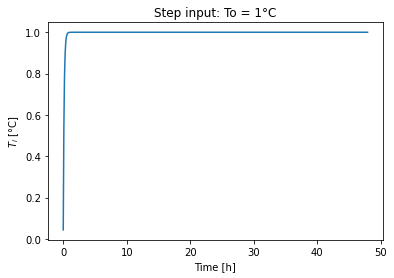

Steady-state indoor temperature obtained with:
- DAE model: 1.0000 °C
- response to step input: 1.0000000000000038 °C


/tmp/ipykernel_72/608677875.py:546: RuntimeWarning: overflow encountered in matmul
  temp_exp[:, k + 1] = (I + dt * As) @ temp_exp[:, k]\
/tmp/ipykernel_72/608677875.py:546: RuntimeWarning: invalid value encountered in matmul
  temp_exp[:, k + 1] = (I + dt * As) @ temp_exp[:, k]\
/tmp/ipykernel_72/608677875.py:550: RuntimeWarning: invalid value encountered in matmul
  y_exp = Cs @ temp_exp + Ds @ u.to_numpy().T


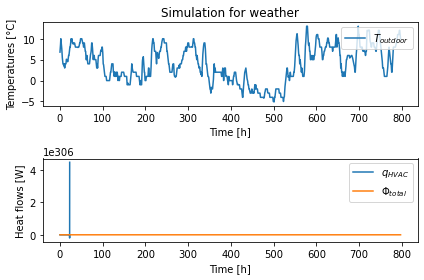

In [1]:

"""
Created on Thu Jun  9 15:36:30 2022
@author: victo
"""

import numpy as np
import pandas as pd
import dm4bem
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('always')


#P-controler gain
Kp = 10000            # almost perfect controller Kp -> ∞
#Kp = 1e-3           # no controller Kp -> 0

longueur_piece = 6.93
largeur_piece = 4.11
hauteur_piece = 2.4

#The building is ventilated : volumis air rate Va_dot
Va = longueur_piece*largeur_piece*hauteur_piece          # m³ volume of air
ACH = 1             # air changes per hour
Va_dot = ACH * Va / 3600    # m³/s air infiltration


#The thermophysical propoerties of air:

air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/kg.K


# Specific heat (J/kgK)

ca = 1006  # air
cc = 880   # concrete
ci = 850   # insulation
cg = 730   # glass
cw = 2700  # wood

# Density (kg/m3)

da = 1.208  # air
dc = 2300   # concrete
di = 22     # insulation
dg = 2210   # glass
dw = 532    # wood

# Lambda (W/mK)

l_air = 0.244             # air
l_concrete = 1.8        # concrete
l_insulation = 0.0345   # insulation
l_glass = 1.4               # glass
l_wood = 0.15           # wood

# épaisseurs (m)
w_wood = 0.03
w_glass = 0.02
w_concrete =0.13
w_insulation = 0.1

# Geometry
# --------
l = 7.23            # m length of the room
L=4.49              # m width of the room
H=2.40              # height oh the swedish room  
Sg = 2                # m² surface of the glass
Sc = Si = 2*(l+L)*H   # m² surface of concrete & insulation of the 5 walls

Sc1 =13.632 #c for concrete
Sc2 =14.904
Sc3 =5.664
Sc4=10.632
Si1=13.632  #i for insulation
Si3=5.664
Si4=10.632
Sg=3        # g for all glass window
Sw2=14.904  # wood inthe wall 2
Swb=2.1     # wooden bathroom's door
Swc=2.1     # wooden corridor's door


#Creation de classes
   # Specific heat (J/kgK)

wall1 = {'Conductivity': [cc * Sc1 * w_concrete * l_concrete, ci * Si1 * w_insulation * l_insulation],  # W/m.K
        'Density': [dc,di],        # kg/m³
        'Specific heat': [cc, ci],  # J/kg.K
        'Width': [w_concrete, w_insulation],
        'Surface': [Sc1, Si1],  # m²
        }                # number of discretizations

wal1l = pd.DataFrame(wall1, index=['Concrete', 'Insulation'])
wall1

windows1 ={'Conductivity': [1.4] , # W/m.K
        'Density': [dg],        # kg/m³
        'Specific heat': [cg],  # J/kg.K
        'Width': [w_glass],
        'Surface': [Sg],  # m²
        }   
windows1 = pd.DataFrame(windows1, index=['Glass'])
windows1


wall_2 = {'Conductivity': [cc * Sc2 * w_concrete * l_concrete, cw * Sw2 * w_wood *l_wood ],  # W/m.K
        'Density': [dc, dw],        # kg/m³
        'Specific heat': [cc, cw],  # J/kg.K
        'Width': [w_concrete, w_wood],
        'Surface': [Sc2, Sw2],  # m²
       }                # number of discretizations
wall_2 = pd.DataFrame(wall_2, index=['Concrete', 'Wood'])

wall_3 = {'Conductivity': [cc * Sc3 * w_concrete * l_concrete, ci * Si3 * w_insulation * l_insulation],  # W/m.K
        'Density': [dc,di],        # kg/m³
        'Specific heat': [cc, ci],  # J/kg.K
        'Width': [w_concrete, w_insulation],
        'Surface': [Sc3, Si3],  # m²
        }                # number of discretizations
wall_3 = pd.DataFrame(wall_3, index=['Concrete', 'Insulation'])

wall_4 = {'Conductivity': [cc * Sc4 * w_concrete * l_concrete, ci * Si4 * w_insulation * l_insulation],  # W/m.K
        'Density': [dc,di],        # kg/m³
        'Specific heat': [cc, ci],  # J/kg.K
        'Width': [w_concrete, w_insulation],
        'Surface': [Sc4, Si4],  # m²
        }                # number of discretizations
wall_4 = pd.DataFrame(wall_4, index=['Concrete', 'Insulation'])

door_bathroom = {'Conductivity': [0.16],  # W/m.K
        'Density': [dw],        # kg/m³
        'Specific heat': [cw],  # J/kg.K
        'Width': [w_wood],
        'Surface': [Swb],  # m²
       }                # number of discretizations
door_bathroom = pd.DataFrame(door_bathroom, index=['Wood'])

door_corridor = {'Conductivity': [0.16],  # W/m.K
        'Density': [dw],        # kg/m³
        'Specific heat': [cw],  # J/kg.K
        'Width': [w_wood],
        'Surface': [Swc],  # m²
       }                # number of discretizations
door_corridor = pd.DataFrame(door_corridor, index=['Wood'])

#The radiative properties of the surfaces are:

ε_wLW = 0.9     # long wave wall emmisivity (concrete)
α_wSW = 0.2     # absortivity white surface
ε_gLW = 0.9     # long wave glass emmisivity (glass pyrex)
τ_gSW = 0.83    # short wave glass transmitance (glass)
α_gSW = 0.1     # short wave glass absortivity

σ = 5.67e-8     # W/m².K⁴ Stefan-Bolzmann constant

Fwg = 1 / 5     # view factor wall - glass

Tm = 20 + 273   # mean temp for radiative exchange

# convection coefficients, W/m² K
h = pd.DataFrame([{'in': 4., 'out': 10}])

# Construction de G

g=np.zeros([33])

hout = 25  #coefficient convection de l’air
hin = 8 

#Mur extérieur : 
g[0] = hout * Sc1
g[1] = 2*l_concrete * Sc1 / w_concrete
g[2] = 2*l_concrete * Sc1 / w_concrete
g[3] = 2*l_insulation * Si1 / w_insulation
g[4]= 2*l_insulation * Si1 / w_insulation
g[5] = hin * Si1

# Mur pièce principale - bathroom : 
g[6] = hin * Sw2
g[7] = 2*l_wood * Sw2 / w_wood
g[8] = 2*l_wood * Sw2 / w_wood
g[9] = 2*l_concrete * Sc2 / w_concrete
g[10] = 2*l_concrete * Sc2 / w_concrete
g[11] = hin * Sc2

# Door, bathroom : 
g[12] = hin * Swb
g[13] = 2*l_wood * Swb / w_wood
g[14] = hin * Swb

#Windows : 
g[15] = hout * Sg
g[16] = hin * Sg

#Mur pièce principale - corridor : 
g[17] = hin * Si3
g[18] = 2*l_insulation * Si3 / w_insulation
g[19] = 2*l_insulation * Si3 / w_insulation
g[20] = 2*l_concrete * Sc3 / w_concrete
g[21] = 2*l_concrete * Sc3 / w_concrete
g[22] = hin * Sc3

# Door pièce principale - corridor :
g[23] = hin * Swc
g[24] = 2*l_wood * Swc / w_wood
g[25] = hin * Swc

# Mur bathroom - corridor :
g[26] = hin * Si4
g[27] = 2*l_insulation * Si4 / w_insulation
g[28] = 2*l_insulation * Si4 / w_insulation
g[29] = 2*l_concrete * Sc4 / w_concrete
g[30] = 2*l_concrete * Sc4 / w_concrete
g[31] = hin * Sc4
g[32] = Kp

G = np.diag(g)

#Thermal conductances Github

# # Conduction
# G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']

# # Convection
# Gw = h * wall['Surface'][0]     # wall
# Gg = h * wall['Surface'][2]     # glass

# # Long-wave radiation exchnage
# GLW1 = ε_wLW / (1 - ε_wLW) * wall['Surface']['Insulation'] * 4 * σ * Tm**3
# GLW2 = Fwg * wall['Surface']['Insulation'] * 4 * σ * Tm**3
# GLW3 = ε_gLW / (1 - ε_gLW) * wall['Surface']['Glass'] * 4 * σ * Tm**3
# # long-wave exg. wall-glass
# GLW = 1 / (1 / GLW1 + 1 / GLW2 + 1 / GLW3)

# # ventilation & advection
Gv = Va_dot * air['Density'] * air['Specific heat']

# # glass: convection outdoor & conduction
#Ggs = float(1 / (1 / Gg['out'] + 1 / (2 * G_cd['Glass'])))



# Construction of C

c = np.zeros([28])

# Mur extérieur : (concrete and insulation)

c[1] = cc * Sc1 * w_concrete * l_concrete
# c[3] = ci * Si1 * w_insulation * l_insulation

# Mur principal room to bathroom:
# S_concrete2 = S_wood2
c[6] = cc * Sc2 * w_concrete * l_concrete
#c[9] = cw * Sw2 * w_wood *l_wood

# Mur principal room to corridor:
# S_concrete3 =S_insulation3

#c[14] = ci * Si3 * w_insulation * l_insulation
c[17] = cc * Sc3 * w_concrete * l_concrete

# Mur bathroom to corridor:

# S_concrete4 =S_insulation4
#c[21] = ci * Si4 * w_insulation * l_insulation
c[24] = cc * Sc4 * w_concrete * l_concrete

C = np.diag(c)


#Github

# C = np.diag([0, C['Concrete'], 0, C['Insulation'], 0, 0,
#             C['Air'], C['Glass']])
##C = np.diag([0, C['Concrete'], 0, C['Insulation'], 0, 0, 0, 0])

print(C)

# Thermal network
A = np.zeros([33, 28])
A[0, 0] = 1
A[1, 0], A[1, 1] = -1, 1
A[2, 1], A[2, 2] = -1, 1
A[3, 2], A[3, 3] = -1, 1
A[4, 3], A[4, 4] = -1, 1
A[5, 4], A[5, 25] = -1, 1
A[6, 25], A[6, 5] = 1, -1
A[7, 5], A[7, 6] = -1, 1
A[8, 6], A[8, 7] = -1, 1
A[9, 7], A[9, 8] = -1, 1
A[10, 8], A[10,9] = -1, 1
A[11, 9], A[11, 26] = -1, 1
A[12, 11], A[12, 25] = -1, 1
A[13, 10], A[13, 11] = -1, 1
A[14, 26], A[14, 10] = -1, 1
A[15, 12] = 1
A[16, 12], A[16, 25] = -1, 1
A[17, 25], A[17, 13] = 1, -1
A[18, 13], A[18, 14] = -1, 1
A[19, 14], A[19, 15] = -1, 1
A[20, 15], A[20, 16] = -1, 1
A[21, 16], A[21, 17] = -1, 1
A[22, 17], A[22, 27] = -1, 1
A[23, 18], A[23, 25] = -1, 1
A[24, 19], A[24, 18] = -1, 1
A[25, 27], A[25, 19] = -1, 1
A[26, 26], A[26, 20] = 1, -1
A[27, 20], A[27, 21] = -1, 1
A[28, 21], A[28, 22] = -1, 1
A[29, 22], A[29, 23] = -1, 1
A[30, 23], A[30, 24] = -1, 1
A[31, 24], A[31, 27] = -1, 1
A[32,25] = 1


#matrice b
Text = 19.5
Troom = 16.4
Tventil = 20.0

# construction of b
b = np.zeros(33)
b[[0, 15, 32]] = 10 + np.array([Text, Troom, Tventil]) # Text = 1, Tcontroller = 20, Tint = 15

# construction of f
f = np.zeros(28)
f[[0,4,5,12,13,25]]=1000 + np.array([1000, 1000, 500, 500,1000,1000])

y = np.ones(28)

u = np.hstack([b[np.nonzero(b)], f[np.nonzero(f)]])


[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)

yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
ytc = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)

print(np.array_str(yss, precision=3, suppress_small=True))
print(np.array_str(ytc, precision=3, suppress_small=True))
print(f'Max error in steady-state between thermal circuit and state-space:\
 {max(abs(yss - ytc)):.2e}')

#dynamic simulation

b = np.zeros(33)
b[[0, 15, 32]] = 1

f = np.zeros(28)
f[[0, 4, 5, 12,13]] = 1

y = np.zeros(28)
y[[27]] = 1 #Let's consider that the output of the circuit is the indoor temperature (i.e. the temperature of node 27)

[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)


#Time step

dtmax = min(-2. / np.linalg.eig(As)[0])
print(f'Maximum time step: {dtmax:.2f} s')


#Let's chose a time step smaller than dtmax

# dt = 5
dt = 360

#Step response 

duration = 3600 * 24 * 2        # [s]

#the number of steps is

n = int(np.floor(duration / dt))

#The time vector (with time step dt) is

t = np.arange(0, n * dt, dt)    # time

#or the input vector u, the outdoor temperatures 
#will be To = 1, the indoor set-point temperature will Tsp =0, 
#and the heat flow sources will be zero.

# Vectors of state and input (in time)
n_tC = As.shape[0]              # no of state variables (temps with capacity)
# u = [To To To Tsp Phio Phii Qaux Phia]
u = np.zeros([8, n])
u[0:3, :] = np.ones([3, n])

temp_exp = np.zeros([n_tC, t.shape[0]])
temp_imp = np.zeros([n_tC, t.shape[0]])

I = np.eye(n_tC)
for k in range(n - 1):
    # temp_exp[:, k + 1] = (I + dt * As) @\
    #     temp_exp[:, k] + dt * Bs @ u[:, k]
    temp_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (temp_imp[:, k] + dt * Bs @ u[:, k])
        
#y_exp = Cs @ temp_exp + Ds @  u
y_imp = Cs @ temp_imp + Ds @  u

fig, ax = plt.subplots()
#ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
ax.plot( t / 3600, y_imp.T)
ax.set(xlabel='Time [h]',
       ylabel='$T_i$ [°C]',
       title='Step input: To = 1°C')
plt.show()

b = np.zeros(33)
b[[0, 15, 32]] = 1
f = np.zeros(28)

ytc = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: {ytc[6]:.4f} °C')
print('- response to step input:', y_imp[0,len(y_imp[0])-1], '°C')
# print(f'- response to step input:{float(y_exp[:, -2]):.4f} °C')

#Simulation with weather data

#Rajout
# construction of b
b = np.zeros(33)
b[[0, 15, 32]] = 10 + np.array([Text, Troom, Tventil]) # Text = 1, Tcontroller = 20, Tint = 15

# construction of f
f = np.zeros(28)
f[[0,4,5,12,13,25]]=1000 + np.array([1000, 1000, 500, 500,1000,1000])

y = np.ones(28)

y[27] = 1

#Rajout 


u = np.hstack([b[np.nonzero(b)], f[np.nonzero(f)]])

filename = 'FRA_Lyon.074810_IWEC.epw'
start_date = '1994-01-03 12:00:00'
end_date = '1994-02-05 18:00:00'

# Read weather data from Energyplus .epw file
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data
weather.index = weather.index.map(lambda t: t.replace(year=1994))
weather = weather[(weather.index >= start_date) & (
    weather.index < end_date)]

surface_orientation = {'slope': 90,
                       'azimuth': 0,
                       'latitude': 45}
albedo = 0.2
rad_surf1 = dm4bem.sol_rad_tilt_surf(weather, surface_orientation, albedo)
rad_surf1['Φt1'] = rad_surf1.sum(axis=1)

data = pd.concat([weather['temp_air'], rad_surf1['Φt1']], axis=1)
data = data.resample(str(dt) + 'S').interpolate(method='linear')
data = data.rename(columns={'temp_air': 'To'})

####"

# data = pd.concat([weather['temp'], rad_surf1['Qray0'],rad_surf1['Qray5']], axis=1)
# data = data.resample(str(dt) + 'S').interpolate(method='linear')
# data = data.rename(columns={'temp_air': 'T0'})


data['Tventil'] = 20 * np.ones(data.shape[0])
data['Troom'] = 16.4 * np.ones(data.shape[0])
data['Q4'] = 1000 * np.ones(data.shape[0])
data['Q9'] = 500 * np.ones(data.shape[0])
data['Q10'] = 500 * np.ones(data.shape[0])
data['Q14'] = 500 * np.ones(data.shape[0])

#####

#Let's consider the indoor temperature setpoint Ti and auxiliary heat flow Qa constant for the whole simulation period.

# data['Ti'] = 20 * np.ones(data.shape[0])
# data['Qa'] = 0 * np.ones(data.shape[0])

#The simulation time vector, at time step dtis:

t = dt * np.arange(data.shape[0])

#The input vector is formed by the temperature sources
#and the heat flow sources

# u = pd.concat([data['To'], data['To'], data['To'], data['Ti'],
#                 α_wSW * wall1['Surface']['Concrete'] * data['Φt1'],
#                 τ_gSW * α_wSW * windows1['Surface']['Glass'] * data['Φt1'],
#                 data['Qa'],
#                 α_gSW * windows1['Surface']['Glass'] * data['Φt1']], axis=1)

# u = pd.concat([data['T0'], data['T0'], data['T0'],data['TH'],data['TH'], data['Tventil'],
#                 α_wSW * wall2['Surface']['parpaing de ciment'] * data['Qray0'],  data['Q4']
#                 ,α_wSW * wall3['Surface']['beton arme'] * data['Qray5'], data['Q9'], data['Q10'], data['Q14'], data['Q20']], axis=1)



u = pd.concat([ data['To'], data['Troom'],data['Tventil'],
                α_wSW * Sc1 *data['Q4'],
                τ_gSW * α_wSW * Sg * data['Q9'],
                data['Q10'],data['Q9'],
                α_gSW * Sc1 * data['Q14']], axis=1)


# #The initial value of the state-vector can be different of zero:

temp_exp = 20 * np.ones([As.shape[0], u.shape[0]])

# #Explicit Euler integration in time

    
# for k in range(u.shape[0] - 1):
#     temp_imp[:, k + 1] = (I - dt * As) @ temp_imp[:, k]\
#         + dt * Bs @ u.iloc[k,:]
        
# y_imp = Cs @ temp_imp + Ds @ u.to_numpy().T
# q_HVAC = Kp * (data['Ti'] - y_imp[0, :])


# fig, axs = plt.subplots(2, 1)
# # plot indoor and outdoor temperature
# axs[0].plot(t / 3600, y_imp[0, :], label='$T_{indoor}$')
# axs[0].plot(t / 3600, data['To'], label='$T_{outdoor}$')
# axs[0].set(xlabel='Time [h]',
#             ylabel='Temperatures [°C]',
#             title='Simulation for weather')
# axs[0].legend(loc='upper right')
    


# #Explicit Euler integration in time

for k in range(u.shape[0]-1):
    #print(k)
    temp_exp[:, k + 1] = (I + dt * As) @ temp_exp[:, k]\
        + dt * Bs @ u.iloc[k, :]
        
        
y_exp = Cs @ temp_exp + Ds @ u.to_numpy().T
q_HVAC = Kp * (data['Troom'] - y_exp[0, :])


fig, axs = plt.subplots(2, 1)
# plot indoor and outdoor temperature
#axs[0].plot(t / 3600, y_exp[0, :], label='$T_{indoor}$')
axs[0].plot(t / 3600, data['To'], label='$T_{outdoor}$')
axs[0].set(xlabel='Time [h]',
            ylabel='Temperatures [°C]',
            title='Simulation for weather')
axs[0].legend(loc='upper right')

# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600,  q_HVAC, label='$q_{HVAC}$')
axs[1].plot(t / 3600, data['Φt1'], label='$Φ_{total}$')
axs[1].set(xlabel='Time [h]',
           ylabel='Heat flows [W]')
axs[1].legend(loc='upper right')

fig.tight_layout()


